<a href="https://colab.research.google.com/github/ygmurkara/DI501/blob/main/Part_1_with_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DI 501: Neural Networks
## Magic Gamma Telescope Classification Comparison

Let's use multi layer perceptrons as the basis of a neural network to solve the magic gamma telescope signal classification problem. First, we will cover some models you tried in your assignments, and others.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, fbeta_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import tree

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

In [ ]:
data = pd.read_csv('magic04.csv')
data['class'] = data['class'].replace({'g': 1, 'h': 0})


/var/folders/5p/rbnmtvhx5437fb_9sp9b1ln80000gn/T/ipykernel_84795/1270525672.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['class'] = data['class'].replace({'g': 1, 'h': 0})


In [ ]:
X, y = data.iloc[:,:-1], data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

np.random.seed(3)
val_ind = np.random.randint(0,len(y_train),len(y_test))
train_ind = set(range(len(X_train)))-set(val_ind)
train_ind = list(train_ind)

def fix_val():
    yield train_ind, val_ind

#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=1)

*Validation set above is defined to be fed into the cross validation term in a grid hyperparameter search defined below for the MLP. All other models were validated with the validation set generated with the last commented out code line.*

To ensure fair comparison between models during hyperparameter tuning, a fixed validation set was defined and used in the cross-validation process. This is especially important when using early stopping: if different validation sets are used in each fold, models may stop at different epochs based on varying validation performance, leading to inconsistent training durations and unfair comparisons. Using the same validation set ensures that all models are evaluated under the same conditions.

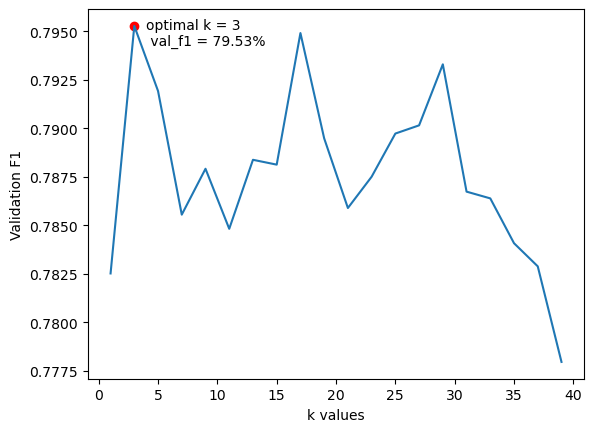

In [ ]:
knn = make_pipeline(StandardScaler(), KNeighborsClassifier())

f1_ = []
k_values = list(range(1,41,2))

for k in k_values:
    knn[1].n_neighbors = k

    knn.fit(X_train, y_train)

    pred_val = knn.predict(X_val)

    #f1_.append(f1_score(y_val, pred_val))
    f1_.append(fbeta_score(y_val, pred_val, beta=2, average='macro'))  # This is a generalized version of the F1 score,
                                                                       # where you can adjust the importance of recall vs. precision
                                                                       # using the beta parameter.

max_k_index = f1_.index(max(f1_))
optimal_k = k_values[max_k_index]

plt.plot(k_values, f1_)
plt.scatter(optimal_k, max(f1_), color='r')
plt.ylabel('Validation F1')
plt.xlabel('k values');
plt.text(optimal_k+1, max(f1_)-0.001, f'optimal k = {optimal_k} \n val_f1 = {max(f1_):.2%}');

An example of how hyperparameter was done for KNN. All other models had their hyperparameters optimized elsewhere.

All models were checked for hyperparameters that gave the best FBeta score (beta=2) on the validation set.



## ROC Curves, Partial AUC and Detection Error Threshold Curves

Models tried can be identified from the legend on the right chart. The legend on the left chart shows partial auc values for the defined threshold at the top.

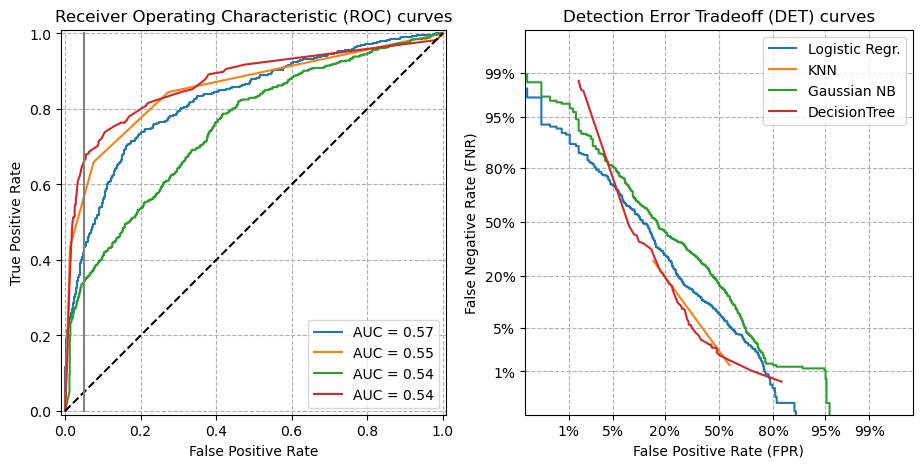

In [ ]:
thresh = 0.05

scale_pipe = lambda x: make_pipeline(StandardScaler(), x)

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

classifiers = [('Logistic Regr.', LogisticRegression(solver='saga',penalty='l2',
                                                     max_iter=1000,C=4000)),
                ('KNN', KNeighborsClassifier(n_neighbors=3)),
                ('Gaussian NB', GaussianNB()),
                ('DecisionTree', DecisionTreeClassifier(max_depth=8, min_samples_leaf=1))

                ]


for name, clf in classifiers:
    pipe = scale_pipe(clf)
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)

    tpr, fpr, _ = roc_curve(y_test, proba[:,0])

    p_auc = roc_auc_score(y_test, proba[:,1], max_fpr=thresh)

    dd = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=p_auc)
    dd.plot(ax=ax_roc)
    DetCurveDisplay.from_estimator(pipe, X_test, y_test, ax=ax_det, name=name, response_method='predict_proba')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")


ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

ax_roc.plot((0,1), (0,1), linestyle='--', color='k')
ax_roc.plot((thresh,thresh), (0,1), color='gray')


ax_det.set_title("Detection Error Tradeoff (DET) curves")
ax_det.set_xlabel("False Positive Rate (FPR)")
ax_det.set_ylabel("False Negative Rate (FNR)")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()




Below is a demonstration on how models rank differently with different areas considered for the AUC score. (DT performs way better, close to KNN level, but this disappears in partial AUC comparisons.)

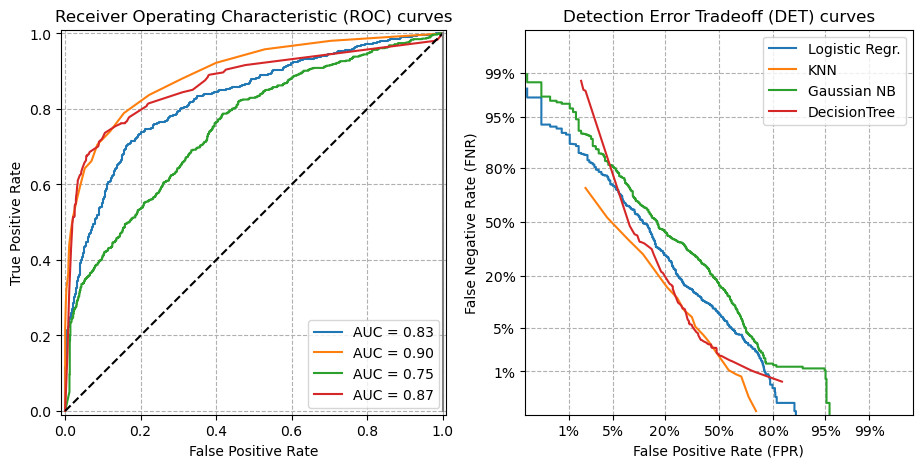

In [ ]:
thresh = 1

scale_pipe = lambda x: make_pipeline(StandardScaler(), x)

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

classifiers = [('Logistic Regr.', LogisticRegression(solver='saga',penalty='l2',
                                                     max_iter=1000,C=4000)),
                ('KNN', KNeighborsClassifier(n_neighbors=21)),
                ('Gaussian NB', GaussianNB()),
                ('DecisionTree', DecisionTreeClassifier(max_depth=8, min_samples_leaf=1)),
                ]

for name, clf in classifiers:
    pipe = scale_pipe(clf)
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)

    tpr, fpr, _ = roc_curve(y_test, proba[:,0])

    p_auc = roc_auc_score(y_test, proba[:,1], max_fpr=thresh)

    dd = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=p_auc)
    dd.plot(ax=ax_roc)
    DetCurveDisplay.from_estimator(pipe, X_test, y_test, ax=ax_det, name=name, response_method='predict_proba')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")


ax_roc.grid(linestyle="--")


ax_roc.plot((0,1), (0,1), linestyle='--', color='k')
ax_roc.plot((thresh,thresh), (0,1), color='gray')

ax_det.set_title("Detection Error Tradeoff (DET) curves")
ax_det.set_xlabel("False Positive Rate (FPR)")
ax_det.set_ylabel("False Negative Rate (FNR)")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

## Multilayer Perceptrons with sci-kit learn

Let's see how an MLP can do against our models. We will define the partial auc scoring with the make_scorer function.

While there are many hyperparameters that go into training an MLP, we will focus on those related to model complexity, specifically, the number of layers and number of neurons per layer.



In [ ]:
# MLP

from sklearn.metrics import roc_auc_score, make_scorer

def partial_auc(y_true, y_score):
    return roc_auc_score(y_true, y_score, max_fpr=0.05)

p_auc_scorer = make_scorer(partial_auc)



# Question 1

Generate a params list that contains combinations of the following:

* Number of neurons per layer: [128, 256, 512]
* Number of hidden layers: [2, 4, 6]

Each entry in params should specify an MLP architecture accordingly.

In [ ]:
params = []

In [ ]:

npl = [128,256,512]
hidd = [2,4,6]

for h in hidd:
    for l in npl:
        params.append({'MLP__hidden_layer_sizes': [tuple([l]*h)]})

Couple things to note here:

* The model was defined inside of a pipeline with a scaler that will unify means and standard deviations of the input features (as they vary a bit in our dataset, this will help the model convergence.)

* Whenever a pipeline is supposed to be optimized, the parameter grid can be define with a key like this: ModelName__parametername. ModelName is whatever name is given in the pipeline definition. A double underscore follows and finally the name of the parameter for that model can be inserted.

* GridSearch is initialized with a single cross-validation fold to save computation time.

* Custom scoring (partial auc up until 0.05 fpr) is used.

* Training as well as validation (called test here) set performances are received.

In [ ]:
mlp_pipe = Pipeline([('Scaler', StandardScaler()),
                     ('MLP',MLPClassifier(random_state=1337,max_iter=400,
                     solver='sgd',learning_rate='adaptive',batch_size=1024))
                    ])

mlp_search = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=params,
    cv=[(train_ind, val_ind.tolist())],
    scoring=p_auc_scorer,
    return_train_score=True,
    verbose=3
)

mlp_search.fit(X_train, y_train)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/1] END MLP__hidden_layer_sizes=(128, 128);, score=(train=0.527, test=0.523) total time=  22.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/1] END MLP__hidden_layer_sizes=(256, 256);, score=(train=0.527, test=0.522) total time=  57.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/1] END MLP__hidden_layer_sizes=(512, 512);, score=(train=0.528, test=0.523) total time= 2.7min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/1] END MLP__hidden_layer_sizes=(128, 128, 128, 128);, score=(train=0.533, test=0.526) total time=  49.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/1] END MLP__hidden_layer_sizes=(256, 256, 256, 256);, score=(train=0.533, test=0.527) total time= 2.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/1] END MLP__hidden_layer_sizes=(512, 512, 512, 512);, score=(train=0.535, test=0.529) total time= 7.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/1] END MLP__hidden_layer_sizes=(128, 128, 128, 128, 128, 128);, score=(train=0.536, test=0.528) total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/1] END MLP__hidden_layer_sizes=(256, 256, 256, 256, 256, 256);, score=(train=0.538, test=0.529) total time= 3.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/1] END MLP__hidden_layer_sizes=(512, 512, 512, 512, 512, 512);, score=(train=0.540, test=0.530) total time=12.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 13, 15, 17, 18, 19, 20, 21,
                   22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, ...],
                  [5994, 1688, 11513, 9859, 9160, 6400, 8981, 11261, 2707,
                   14026, 11115, 7161, 1705, 7818, 7061, 13431, 10720, 13972,
                   14252, 14941, 1447, 6542, 3576, 3610, 12625, 1498, 2710,
                   9026, 2306, 8127, ...])],
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('MLP',
                                        MLPClassifier(ba...
                         {'MLP__hidden_layer_sizes': [(256, 256, 256, 256)]},
                         {'MLP__hidden_layer_sizes': [(512, 512, 512, 512)]},
                         {'MLP__hidden_layer_sizes': [(128, 128, 128, 128, 128,
                                                       128)]},
                         {'MLP__hidden_layer_sizes': [(256, 256, 256, 256, 256,
                                                       256)]},
                         {'MLP__hidden_layer_sizes': [(512, 512, 512, 512, 512,
                                                       512)]}],
             return_train_score=True,
             scoring=make_scorer(partial_auc, response_method='predict'),
             verbose=3)

# Question 2

Using the best model obtained from the hyperparameter search:

* Predict class probabilities on the test set, and

* Compute the partial AUC (with max_fpr = thresh) using the predicted probabilities for the positive class.

In [ ]:
pred_prob = mlp_search.best_estimator_.predict_proba(X_test)
roc_auc_score(y_test, pred_prob[:,1], max_fpr=0.05)

0.6938502377495099

# Question 3

Compare the partial AUC score of the MLPClassifier with the ROC AUC scores of the previously tested models (Logistic Regression, KNN, GaussianNB, Decision Tree).

* Which model performs best, and why might that be?

* In what scenario would the partial AUC be more informative than full AUC?



In this case, the MLPClassifier performs best in terms of partial AUC. This is likely because:

* MLPs can model complex, non-linear decision boundaries due to their multi-layer architecture.
* With proper scaling (via StandardScaler) and optimization, they are more flexible than simpler models like Logistic Regression or Naive Bayes.
* MLPs are better at focusing their decision boundary on high-confidence predictions, which is crucial in the low-FPR region.

Partial AUC is more informative when false positives have a high cost, and we want to evaluate model performance only in a very specific region of the ROC curve (e.g., FPR ≤ 5%).

This is often the case in medical tests such as cancer screening, where a high false positive rate can lead to unnecessary stress and procedures; in fraud or anomaly detection, where false alarms can overwhelm investigation teams; or in security systems, where frequent false positives can reduce trust in alerts. In such situations, evaluating the model only within a specific FPR threshold (e.g., ≤ 5%) provides a clearer picture of how well it performs under strict constraints.

Let's analyze the results closer.

In [ ]:
mlp_search.cv_results_

{'mean_fit_time': array([ 22.48297787,  57.38045692, 161.62616396,  49.29634786,
        145.76976299, 450.42254496,  77.37239695, 234.64163923,
        754.80210614]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.00948095, 0.02191615, 0.07960892, 0.01916313, 0.04049802,
        0.13214183, 0.01961017, 0.05645394, 0.22293091]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_MLP__hidden_layer_sizes': masked_array(data=[(128, 128), (256, 256), (512, 512),
                    (128, 128, 128, 128), (256, 256, 256, 256),
                    (512, 512, 512, 512), (128, 128, 128, 128, 128, 128),
                    (256, 256, 256, 256, 256, 256),
                    (512, 512, 512, 512, 512, 512)],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'MLP__hidden_layer_sizes': (128, 128)},
  {'MLP__hidden_lay

In [ ]:
mlp_search.cv_results_['mean_test_score']

array([0.52297736, 0.52214132, 0.52304047, 0.52611652, 0.52735243,
       0.52857418, 0.52792559, 0.52948614, 0.53009525])

In [ ]:
mlp_search.cv_results_['mean_test_score'].reshape(-1,3)

array([[0.52297736, 0.52214132, 0.52304047],
       [0.52611652, 0.52735243, 0.52857418],
       [0.52792559, 0.52948614, 0.53009525]])

You can see as expected, as model complexity increases, the model is better equipped to give better results. Notice how the best point lies on the edge of the grid. For even better results, values beyond our grid definition need to be searched through.

<Axes: >

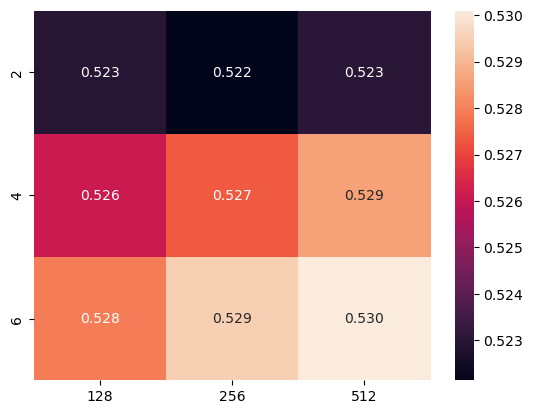

In [ ]:
sns.heatmap(mlp_search.cv_results_['mean_test_score'].reshape(-1,3),
            xticklabels=npl,yticklabels=hidd,annot=True,fmt='.3f')

Just to see how model training can be inspected, here the model is trained with verbose set to 3 so that each iteration, loss, and possible signs of failure in convergence or other errors can be seen. The training was stopped manually.

In [ ]:
mlp2_pipe = Pipeline([('Scaler', StandardScaler()),
                     ('MLP',MLPClassifier(hidden_layer_sizes=[512, 512, 512, 512, 512, 512],
                     random_state=1337,max_iter=400,
                     solver='sgd',learning_rate='adaptive',batch_size=1024,verbose=3))
                    ])

mlp2_pipe.fit(X_train, y_train)

Iteration 1, loss = 0.71637290
Iteration 2, loss = 0.69617746
Iteration 3, loss = 0.67821808
Iteration 4, loss = 0.66586484
Iteration 5, loss = 0.65756614
Iteration 6, loss = 0.65163383
Iteration 7, loss = 0.64707288
Iteration 8, loss = 0.64338065
Iteration 9, loss = 0.64005905
Iteration 10, loss = 0.63694979
Iteration 11, loss = 0.63386471
Iteration 12, loss = 0.63077928
Iteration 13, loss = 0.62754340
Iteration 14, loss = 0.62418693
Iteration 15, loss = 0.62060345
Iteration 16, loss = 0.61679599
Iteration 17, loss = 0.61271261
Iteration 18, loss = 0.60832796
Iteration 19, loss = 0.60361899
Iteration 20, loss = 0.59857217
Iteration 21, loss = 0.59306062
Iteration 22, loss = 0.58716875
Iteration 23, loss = 0.58088213
Iteration 24, loss = 0.57419571
Iteration 25, loss = 0.56706824
Iteration 26, loss = 0.55953211
Iteration 27, loss = 0.55158673
Iteration 28, loss = 0.54339432
Iteration 29, loss = 0.53500608
Iteration 30, loss = 0.52648486
Iteration 31, loss = 0.51796486
Iteration 32, los

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(steps=[('Scaler', StandardScaler()),
                ('MLP',
                 MLPClassifier(batch_size=1024,
                               hidden_layer_sizes=[512, 512, 512, 512, 512,
                                                   512],
                               learning_rate='adaptive', max_iter=400,
                               random_state=1337, solver='sgd', verbose=3))])

In [ ]:
mlp2_pipe[1]

MLPClassifier(batch_size=1024,
              hidden_layer_sizes=[512, 512, 512, 512, 512, 512],
              learning_rate='adaptive', max_iter=400, random_state=1337,
              solver='sgd', verbose=3)

And the loss curve can be accessed like the following:

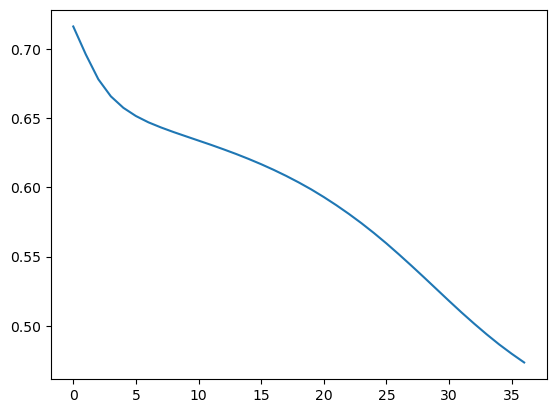

In [ ]:
plt.plot(mlp2_pipe[1].loss_curve_)